# Midiendo rendimiento y riesgo con datos históricos

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Copper_Price_History_USD.png" width="600px" height="400px" />

> Ya sabemos que podemos caracterizar la distribución de rendimientos de un activo mediante una medida de tendencia central (media: rendimiento esperado) y una medida de dispersión (desviación estándar: volatilidad). 

> En la clase pasada vimos como obtener reportes históricos de precios de activos. ¿Cómo usamos estos históricos para medir el rendimiento esperado y la volatilidad de los rendimientos?

*Objetivos:*
- Calcular los rendimientos a partir de históricos de precios.
- Estimar rendimiento esperado y riesgo a partir de históricos de rendimientos.
- Anualizar rendimiento y volatilidad cuando los datos están en una base de tiempo menor.
- Verificar la relación entre rendimiento y riesgo a través de datos reales.

**Referencias:**
- http://pandas.pydata.org/
- https://pandas-datareader.readthedocs.io/en/latest/
- Notas del curso "Portfolio Selection and Risk Management", Rice University, disponible en Coursera.
___

## 1. Cálculo de los rendimientos

Muy bien, ya entonces sabemos descargar históricos de precios...

**Ejemplo:** trabajaremos esta clase con activos que se encuentran en el top-10 del índice S&P500. Descargar precios ajustados en el cierre de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (FB) y Alphabet Inc. (GOOGL) desde el primero de enero del 2015 hasta hoy.

In [1]:
# Importar paquetes
import pandas_datareader.data as web
import yfinance as yf
import pandas as pd
import numpy as np
%matplotlib inline

yf.pdr_override()

In [10]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers,
                   start_date=None,
                   end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.get_data_yahoo(
        tickers=tickers,
        start=start_date,
        end=end_date
    )
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [11]:
# Información
tickers = ["MSFT", "AAPL", "AMZN", "META", "GOOGL"]
start_date = "2015-01-01"

In [12]:
# Precios diarios ajustados en el cierre
closes = get_adj_closes(tickers, start_date)

[*********************100%***********************]  5 of 5 completed


In [13]:
closes.head()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-02,24.603203,15.4260,26.477501,78.449997,40.811428
2015-01-05,23.910095,15.1095,25.973000,77.190002,40.436131
2015-01-06,23.912342,14.7645,25.332001,76.150002,39.842640
2015-01-07,24.247650,14.9210,25.257500,76.150002,40.348854
2015-01-08,25.179298,15.0230,25.345501,78.180000,41.535839


<AxesSubplot:xlabel='Date'>

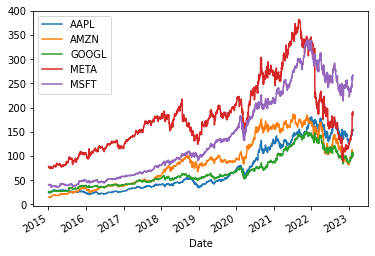

In [20]:
# Gráfico de histórico de precios diarios
closes.plot()

### 1.1. Rendimientos porcentuales

Muy bien, pero para el análisis no trabajamos con los precios sino con los rendimientos... **¿porqué?**

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual
$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}
$$
para $t=1,\ldots,n$.

*¡Cuidado!* los rendimientos son de acuerdo a la base de tiempo en que se reportan los precios. Por ejemplo: 
- si los precios se reportan en una base diaria, los rendimientos también son diarios;
- si los precios se reportan en una base mensual, los rendimientos también son mensuales.

In [21]:
# S_t
closes.head()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-02,24.603207,15.4260,26.477501,78.449997,40.811440
2015-01-05,23.910095,15.1095,25.973000,77.190002,40.436127
2015-01-06,23.912346,14.7645,25.332001,76.150002,39.842632
2015-01-07,24.247648,14.9210,25.257500,76.150002,40.348854
2015-01-08,25.179296,15.0230,25.345501,78.180000,41.535835


In [22]:
# S_{t-1}
closes.shift().head()

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,24.603207,15.4260,26.477501,78.449997,40.811440
2015-01-06,23.910095,15.1095,25.973000,77.190002,40.436127
2015-01-07,23.912346,14.7645,25.332001,76.150002,39.842632
2015-01-08,24.247648,14.9210,25.257500,76.150002,40.348854


In [14]:
# Calcular rendimientos
st = closes
st_1 = closes.shift()
ret = ((st - st_1) / st_1).dropna()

In [16]:
# Lo mismo que:
ret = closes.pct_change().dropna()

`NaN`: Not A Number

In [17]:
ret

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-05,-0.028171,-0.020517,-0.019054,-0.016061,-0.009196
2015-01-06,0.000094,-0.022833,-0.024679,-0.013473,-0.014677
2015-01-07,0.014022,0.010600,-0.002941,0.000000,0.012705
2015-01-08,0.038422,0.006836,0.003484,0.026658,0.029418
2015-01-09,0.001072,-0.011749,-0.012211,-0.005628,-0.008405
...,...,...,...,...,...
2023-02-03,0.024400,-0.084315,-0.027474,-0.011866,-0.023621
2023-02-06,-0.017929,-0.011703,-0.017942,-0.002520,-0.006116
2023-02-07,0.019245,-0.000685,0.046064,0.029883,0.042022


<AxesSubplot:xlabel='Date'>

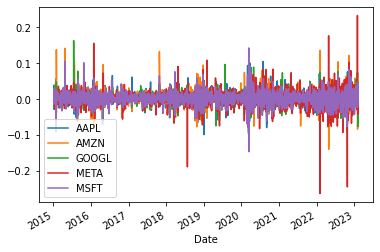

In [34]:
# Graficar...
ret.plot()

**¿Qué se observa respecto a los precios?**

Respuestas:
- Los rendimientos parecen conservar tendecias estadísticas constantes (por ejemplo, oscilan al rededor de números cercanos a cero). 

### 1.2. Rendimientos logarítmicos (log-rendimientos)

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logaritmico. Éste, está definido como

$$
r_t=\ln\left(\frac{S_t}{S_{t-1}}\right).
$$

Es fácil darse cuenta que $r_t=\ln(1+R_t)$.

<font color=blue>Ver en el tablero</font> que si $0\leq|x|\ll 1$, entonces $\ln(1+x)\approx x$.

In [36]:
%timeit np.log(st).diff()

114 µs ± 2.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
%timeit np.log(st / st_1)

163 µs ± 568 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [39]:
# Una forma más eficiente:
logret = np.log(st).diff().dropna()
logret

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-05,-0.028576,-0.020731,-0.019238,-0.016191,-0.009239
2015-01-06,0.000094,-0.023098,-0.024989,-0.013565,-0.014786
2015-01-07,0.013925,0.010544,-0.002945,0.000000,0.012625
2015-01-08,0.037702,0.006813,0.003478,0.026309,0.028994
2015-01-09,0.001072,-0.011818,-0.012286,-0.005644,-0.008440
...,...,...,...,...,...
2023-02-02,0.036392,0.071203,0.070260,0.209307,0.045818
2023-02-03,0.024107,-0.088083,-0.027858,-0.011937,-0.023904
2023-02-06,-0.018091,-0.011772,-0.018105,-0.002523,-0.006135


In [40]:
# Recordar rendimientos porcentuales. Ver que son similares
np.abs(ret-logret)

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2015-01-05,4.044330e-04,2.134036e-04,0.000184,0.000130,0.000043
2015-01-06,4.430006e-09,2.647179e-04,0.000310,0.000092,0.000109
2015-01-07,9.740080e-05,5.578340e-05,0.000004,0.000000,0.000080
2015-01-08,7.197546e-04,2.325964e-05,0.000006,0.000349,0.000424
2015-01-09,5.746937e-07,6.956028e-05,0.000075,0.000016,0.000036
...,...,...,...,...,...
2023-02-03,2.929222e-04,3.767858e-03,0.000384,0.000071,0.000283
2023-02-06,1.626687e-04,6.902209e-05,0.000163,0.000003,0.000019
2023-02-07,1.828372e-04,2.347626e-07,0.001029,0.000438,0.000859


Por lo anterior, muchas veces se usan para el análisis los rendimientos continuamente compuestos.
___

## 2. Caracterización de la distribución de los rendimientos

Entonces:
- partimos de que tenemos los rendimientos porcentuales diarios de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (FB) y Alphabet Inc. (GOOGL) desde inicios del 2011 a finales del 2015;
- ¿cómo resumirían estos datos?

In [41]:
# Rendimiento medio diario (media aritmética)
ret.mean()

AAPL     0.001074
AMZN     0.001143
GOOGL    0.000810
META     0.000710
MSFT     0.001079
dtype: float64

In [42]:
# Volatilidad diaria (desviación estándar)
ret.std()

AAPL     0.018849
AMZN     0.021135
GOOGL    0.018023
META     0.024013
MSFT     0.017793
dtype: float64

In [45]:
# Podemos resumir en un DataFrame
summary_daily = pd.DataFrame({
    "mean": ret.mean(),
    "vol": ret.std()
}).T
summary_daily

,AAPL,AMZN,GOOGL,META,MSFT
mean,0.001074,0.001143,0.000810,0.000710,0.001079
vol,0.018849,0.021135,0.018023,0.024013,0.017793


Normalmente se reportan rendimientos esperados y volatilidades en una base anual. Para anualizar:

$$E[r_a]=12E[r_m]=252E[r_d]=52E[r_w],\text{ y}$$

$$\sigma_{r_a}=\sqrt{12}\sigma_{r_m}=\sqrt{252}\sigma_{r_d}=\sqrt{52}\sigma_{r_w}$$

In [50]:
# Resumen en base anual
summary_annual = pd.DataFrame({"media": ret.mean()*252, "vol": ret.std()*(252)**0.5}).T
summary_annual

,AAPL,AMZN,GOOGL,META,MSFT
media,0.270613,0.287993,0.204215,0.178918,0.271858
vol,0.299223,0.335511,0.286111,0.381196,0.282458


In [51]:
from matplotlib import pyplot as pt

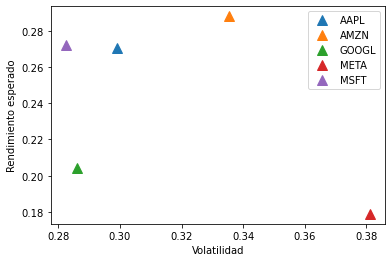

In [52]:
# Gráfico rendimiento esperado vs. volatilidad
for col in summary_annual:
    pt.plot(summary_annual.loc["vol", col], summary_annual.loc["media", col], "^", ms=10, label=col)
    pt.legend()
    pt.xlabel("Volatilidad")
    pt.ylabel("Rendimiento esperado")

### 2.1 Ajuste de curvas con mínimos cuadrados
Consideramos que tenemos un conjunto de n pares ordenados de datos $(\sigma_{r_i},E[r_i])$, para $i=1,2,3,\dots,n$... **en este caso corresponden a volatilidad y rendimiento esperado**

#### ¿Cuál es la recta que mejor se ajusta a estos datos?
Consideramos entonces ajustes de la forma $\hat{f}(\sigma) = \beta_0+\beta_1 \sigma = \left[1 \quad \sigma\right]\left[\begin{array}{c} \beta_0 \\ \beta_1 \end{array}\right]=\left[1 \quad \sigma\right]\boldsymbol{\beta}$ (lineas rectas).

Para decir '*mejor*', tenemos que definir algún sentido en que una recta se ajuste *mejor* que otra.

**Mínimos cuadrados**: el objetivo es seleccionar los coeficientes $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$, de forma que la función evaluada en los puntos $\sigma_{r_i}$ ($\hat{f}(\sigma_{r_i})$) aproxime los valores correspondientes $E[r_i]$.

La formulación por mínimos cuadrados, encuentra los $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$ que minimiza
$$\sum_{i=1}^{n}(E[r_i]-\hat{f}(\sigma_{r_i}))^2$$

In [53]:
# Importar el módulo optimize de la librería scipy
from sklearn.linear_model import LinearRegression

In [54]:
# Instanciamos la regresión lineal
model = LinearRegression()

In [55]:
summary_annual.loc["vol"].values

array([0.29922306, 0.33551132, 0.28611144, 0.38119619, 0.28245791])

In [58]:
volu = summary_annual.loc["vol"].values.reshape([-1, 1])

In [59]:
# Resolver problema de optimizacion
model.fit(X=volu, y = summary_annual.loc["media"].values)

LinearRegression()

In [61]:
b0 = model.intercept_
b1 = model.coef_
b0, b1

(0.40607542744850117, array([-0.51548161]))

In [62]:
# Cálculo de bondad de ajuste através de R^2
model.score(X=volu, y = summary_annual.loc["media"].values)

0.1994218883755572

Text(0, 0.5, 'Rendimiento esperado')

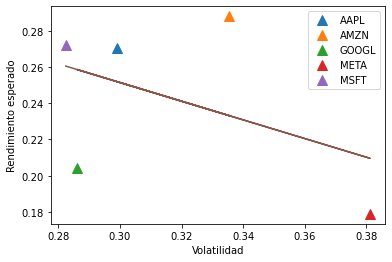

In [63]:
for col in summary_annual:
    pt.plot(summary_annual.loc["vol", col], summary_annual.loc["media", col], "^", ms=10, label=col)

# Gráfico de la recta
pt.plot(summary_annual.loc["vol"].values, model.predict(volu))
    
pt.legend()
pt.xlabel("Volatilidad")
pt.ylabel("Rendimiento esperado")

Sacando META de la solución, ya que el punto relativo de META hace que la varianza explicada sea pésima

In [64]:
summary_annual.loc["vol"].drop("META")

AAPL     0.299223
AMZN     0.335511
GOOGL    0.286111
MSFT     0.282458
Name: vol, dtype: float64

In [65]:
model = LinearRegression().fit(
    X=summary_annual.loc["vol"].drop("META").values.reshape(-1, 1),
    y=summary_annual.loc["media"].drop("META").values
)
b0 = model.intercept_
b1 = model.coef_
b0, b1

(-0.007523869708605746, array([0.88487573]))

In [67]:
model.score(
    X=summary_annual.loc["vol"].drop("META").values.reshape(-1, 1),
    y=summary_annual.loc["media"].drop("META").values
)

0.33264875796597837

Text(0, 0.5, 'Rendimiento esperado')

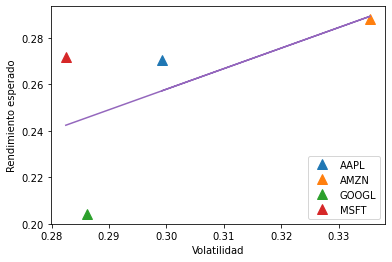

In [72]:
for col in summary_annual:
    if col != "META":
        pt.plot(
            summary_annual.loc["vol", col],
            summary_annual.loc["media", col],
            "^",
            ms=10,
            label=col
        )
# Gráfico de la recta
pt.plot(
    summary_annual.loc["vol"].drop("META").values,
    model.predict(summary_annual.loc["vol"].drop("META").values.reshape(-1, 1)),
)
pt.legend()
pt.xlabel("Volatilidad")
pt.ylabel("Rendimiento esperado")

In [73]:
b0, b1

(-0.007523869708605746, array([0.88487573]))

**¿Qué se puede concluir acerca de la relación entre riesgo (medido con la volatilidad) y el rendimiento esperado (medido con la media)?**

Respuestas:
- La pendiente de la recta es positiva, lo que confirma la relación positiva entre rendimiento esperado y riesgo.
- Si el mercado solo estuviera dado por los cuatro activos analizados (GOOGL, MSFT, AAPL, AMZN), la tasa libre de riesgo sería $-0.007$.
- Por cada unidad de riesgo (volatilidad), el rendimiento esperado aumenta $0.88$.

## 3. Comentarios finales acerca del uso de datos históricos.

### ¡Cuidado!
- Es cierto que los patrones que vemos sobre periodos largos de tiempo en diferentes tipos de intrumentos son muy robustos en términos de la relación rendimiento/riesgo (positiva).
- Por tanto, esperamos rendimientos más altos en el futuro cuando asumimos cierto riesgo.
- ¿Cómo encontramos ese 'rendimiento esperado'? Datos históricos (humanos: tendencia a generalizar)

- Entonces, la idea es que si los rendimientos esperados son un p.e. estacionario, el promedio de muchos rendimientos pasados es una buena estimación del rendimiento esperado futuro (Teorema del límite central).
- ¿Deberíamos pensarlo dos veces?

## SI

Problemas:
- La muestra de datos en el periodo específico de tiempo puede estar sesgada.
- Ventanas de tiempo más grandes reducen especificidad de la muestra y estimados más precisos.
 - Aún así, datos muy viejos pueden ser no representativos.
- Nuevos fondos o estrategias de inversión están a menudo sesgados positivamente:
 - reporte de resultados en tiempos voluntarios;
 - las que mueren (no funcionan), no se reportan;

# Anuncios parroquiales:
## 1. Fin Módulo 1. Revisar que se hayan cumplido los objetivos del módulo (Clase0)
## 2. Tarea: revisar archivo "Tarea3_MidiendoRendimientoRiesgo" en clase. Para el lunes 14 de febrero.
## 3. Recordar quiz la siguiente clase.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>